In [1]:
!pip install -e .. > /dev/null 2>&1

In [2]:
import os
import json
import gdown
import shutil
import astrohack

import matplotlib.pyplot as plt

from astrohack.gdown_utils import gdown_data
from astrohack.gdown_utils import build_folder_structure

from astrohack.dio import open_pointing

plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
# Build folder structure & download 

datafolder = 'data'
resultsfolder = 'results'

build_folder_structure(datafolder, resultsfolder)


astrohack.gdown_utils.download('J1924-2914.ms.calibrated.split.SPW3', folder=datafolder, unpack=True)
astrohack.gdown_utils.download(file='extract_holog_verification.json')
astrohack.gdown_utils.download(file='holog_numerical_verification.json')


In [4]:
from astrohack.astrohack_client import astrohack_local_client

log_parms = {'log_level':'DEBUG'}

client = astrohack_local_client(cores=2, memory_limit='8GB', log_parms=log_parms)

2023-07-21 11:19:02,776 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_term to True.
2023-07-21 11:19:02,780 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_file to False.
2023-07-21 11:19:02,783 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_file to hack_.
2023-07-21 11:19:02,784 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_term to False.
2023-07-21 11:19:02,786 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_file to False.
2023-07-21 11:19:02,788 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_file to hack_.
2023-07-21 11:19:02,790 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_level to INFO.
2023-07-21 11:19:04,424 - INFO     - astroha

In [5]:
def test_holog_obs_dictionary(holog_obs_dict):
    import os
    import json
    import copy
    
    import numpy as np

    from astrohack._utils._tools import _jsonify

    ref_holog_obj = {}
    ref_holog_obj = copy.deepcopy(holog_obs_dict)

    _jsonify(ref_holog_obj)

    with open(".holog_obs_dict.json") as json_file:
        holog_obj = json.load(json_file)
                          
    assert holog_obj == ref_holog_obj, "Error: holog_obs_descrition dictionary has changes unexpectedly."
    
def test_holog_diagnostics(json_data, tolerance=1e-7):
    import json
    
    with open("holog_numerical_verification.json") as file:
        reference_dict = json.load(file)
        
    cell_size = reference_dict["alma"]['cell_size'][1]
    grid_size = float(reference_dict["alma"]['grid_size'][1])
    
    json_data['cell_size'] = np.abs(float(json_data['cell_size']))
    
    cell_size = np.abs(float(cell_size))
    
    assert relative_difference(json_data['cell_size'], cell_size) < tolerance, "Unexpected change in cell_size occured."
    assert relative_difference(np.sqrt(int(json_data['n_pix'])), grid_size) < tolerance, "Unexpected change in grid_size occured."

    
def test_center_pixel(file, antenna, ddi, reference_center_pixels, number_of_digits=7):
    from astrohack.dio import open_image
    
    mds = open_image(file)[antenna][ddi]
    
    aperture_shape = mds.APERTURE.values.shape[-2], mds.APERTURE.values.shape[-1]
    beam_shape = mds.BEAM.values.shape[-2], mds.BEAM.values.shape[-1]  
    
    aperture_center_pixels = np.squeeze(mds.APERTURE.values[..., aperture_shape[0]//2, aperture_shape[1]//2])
    beam_center_pixels = np.squeeze(mds.BEAM.values[..., beam_shape[0]//2, beam_shape[1]//2])
    
    aperture_ref = list(map(complex, reference_center_pixels['aperture']))
    beam_ref = list(map(complex, reference_center_pixels['beam']))
    
    for i in range(len(aperture_ref)):
        assert relative_difference(
            aperture_ref[i].real, 
            aperture_center_pixels[i].real
        ) < 1e-6, "There has been a shift in aperture center pixel value(s)"
        
        assert relative_difference(
            beam_ref[i].real, 
            beam_center_pixels[i].real
        ) < 1e-6, "There has been a shift in beam center pixel value(s)"
                
        assert relative_difference(
            aperture_ref[i].imag, 
            aperture_center_pixels[i].imag
        ) < 1e-6, "There has been a shift in aperture center pixel value(s)"
        assert relative_difference(
            beam_ref[i].imag, 
            beam_center_pixels[i].imag
        ) < 1e-6, "There has been a shift in beam center pixel value(s)"
        
    
def get_center_pixel(file, antenna, ddi):
    from astrohack.dio import open_image
    
    mds = open_image(file)[antenna][ddi]
    
    aperture_shape = mds.APERTURE.values.shape[-2], mds.APERTURE.values.shape[-1]
    beam_shape = mds.BEAM.values.shape[-2], mds.BEAM.values.shape[-1]    
    
    aperture_center_pixels = mds.APERTURE.values[..., aperture_shape[0]//2, aperture_shape[1]//2]
    beam_center_pixels = mds.BEAM.values[..., beam_shape[0]//2, beam_shape[1]//2]
    
    return np.squeeze(aperture_center_pixels), np.squeeze(beam_center_pixels)

def compare_float_values(result, reference, decimals):
    result_list = list(map(str, str(result)))
    reference_list = list(map(str, str(reference)))
    
    return result_list[:decimals] == reference_list[:decimals]

def relative_difference(result, expected):
    return 2*np.abs(result - expected)/(abs(result) + abs(expected))

In [6]:
from astrohack.extract_pointing import extract_pointing

alma_ms = "data/J1924-2914.ms.calibrated.split.SPW3"

extract_pointing(
    ms_name=alma_ms,
    point_name='results/alma.split.point.zarr',
    parallel=False,
    overwrite=True
)

2023-07-21 11:19:04,528 - WARNING  - astrohack - (_dio.py:42) - [extract_pointing]: results/alma.split.point.zarr will be overwritten.
Successful readonly open of usernoread-locked table data/J1924-2914.ms.calibrated.split.SPW3/ANTENNA: 8 columns, 2 rows
2023-07-21 11:19:06,919 - DEBUG    - astrohack - (_extract_point.py:85) - Holography Scans Times {0: {2: array([5.04540246e+09, 5.04540315e+09]), 4: array([5.04540328e+09, 5.04540397e+09]), 6: array([5.04540815e+09, 5.04540884e+09]), 8: array([5.04540902e+09, 5.04540971e+09]), 10: array([5.04541404e+09, 5.04541472e+09]), 12: array([5.04541486e+09, 5.04541555e+09])}}
2023-07-21 11:19:07,001 - INFO     - astrohack - (_extract_point.py:256) - Writing pointing xds to results/alma.split.point.zarr/ant_DA44
2023-07-21 11:19:07,091 - INFO     - astrohack - (_extract_point.py:256) - Writing pointing xds to results/alma.split.point.zarr/ant_DV13
2023-07-21 11:19:07,180 - INFO     - astrohack - (extract_pointing.py:102) - [extract_pointing]: Fin

{'point_meta_ds': <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     *empty*
 Attributes:
     mapping_state_ids:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15...,
 'ant_DV13': <xarray.Dataset>
 Dimensions:              (time: 60072, az_el: 2, lm: 2)
 Coordinates:
   * time                 (time) float64 5.045e+09 5.045e+09 ... 5.045e+09
 Dimensions without coordinates: az_el, lm
 Data variables:
     DIRECTION            (time, az_el) float64 dask.array<chunksize=(30036, 1), meta=np.ndarray>
     DIRECTIONAL_COSINES  (time, lm) float64 dask.array<chunksize=(30036, 1), meta=np.ndarray>
     ENCODER              (time, az_el) float64 dask.array<chunksize=(30036, 1), meta=np.ndarray>
     POINTING_OFFSET      (time, az_el) float64 dask.array<chunksize=(30036, 1), meta=np.ndarray>
     TARGET               (time, az_el) float64 dask.array<chunksize=(30036, 1), meta=np.ndarray>
 Attributes:
     ant_name:                DV13
     mapping_scans_obs_dict:  [{'ddi_0': {'map_0': 

In [7]:
import numpy as np

from astrohack.extract_holog import extract_holog

with open("extract_holog_verification.json") as file:
    json_dict = json.load(file)
    
holog_obs_dict = json_dict["alma"]

alma_ms = "data/J1924-2914.ms.calibrated.split.SPW3"
alma_holog = 'results/alma.split.holog.zarr'

extract_holog(
    ms_name=alma_ms,
    holog_name=alma_holog,
    point_name='results/alma.split.point.zarr',
    data_column='DATA',
    parallel=False,
    overwrite=True
)

test_holog_obs_dictionary(holog_obs_dict)

with open('results/alma.split.holog.zarr/.holog_attr') as attr_file:
    holog_attr = json.load(attr_file)
    
test_holog_diagnostics(
    json_data=holog_attr,
    tolerance=2e-5
)

2023-07-21 11:19:07,234 - ERROR    - astrohack - (_dio.py:36) - [extract_holog]: results/alma.split.holog.zarr already exists. To overwite set overwrite to True, or remove current file.
2023-07-21 11:19:07,234 - ERROR    - astrohack - (extract_holog.py:419) - There was an error, extiing.


In [8]:
import numpy as np
from astrohack import holog

with open("holog_numerical_verification.json") as file:
    reference_dict = json.load(file)

grid_interpolation_mode = 'linear' #'nearest' 'linear' 'cubic'
chan_average = True
scan_average = True

holog(
    holog_name=alma_holog, 
    padding_factor=50, 
    grid_interpolation_mode=grid_interpolation_mode,
    chan_average = chan_average,
    scan_average = scan_average,
    overwrite=True,
    phase_fit=True,
    apply_mask=True,
    to_stokes=True,
    parallel=True
)
    
test_center_pixel(
    file="results/alma.split.image.zarr", 
    antenna="ant_DV13", 
    ddi="ddi_0", 
    reference_center_pixels=reference_dict["alma"]['pixels']
)

2023-07-21 11:19:07,283 - INFO     - astrohack - (_check_parms.py:135) - [holog]: Setting default image_name to results/alma.split.image.zarr.
2023-07-21 11:19:07,284 - INFO     - astrohack - (_check_parms.py:135) - [holog]: Setting default ant to all.
2023-07-21 11:19:07,284 - INFO     - astrohack - (_check_parms.py:135) - [holog]: Setting default ddi to all.
2023-07-21 11:19:07,300 - WARNING  - astrohack - (_dio.py:42) - [holog]: results/alma.split.image.zarr will be overwritten.
2023-07-21 11:19:07,311 - INFO     - astrohack - (holog.py:130) - [holog]: Cell size: [-5.47204107e-05  5.47204107e-05], Grid size [49 49]
2023-07-21 11:19:11,619 - INFO     - astrohack - (holog.py:148) - [holog]: Finished processing


-24.88936382826427 24.88936382826427


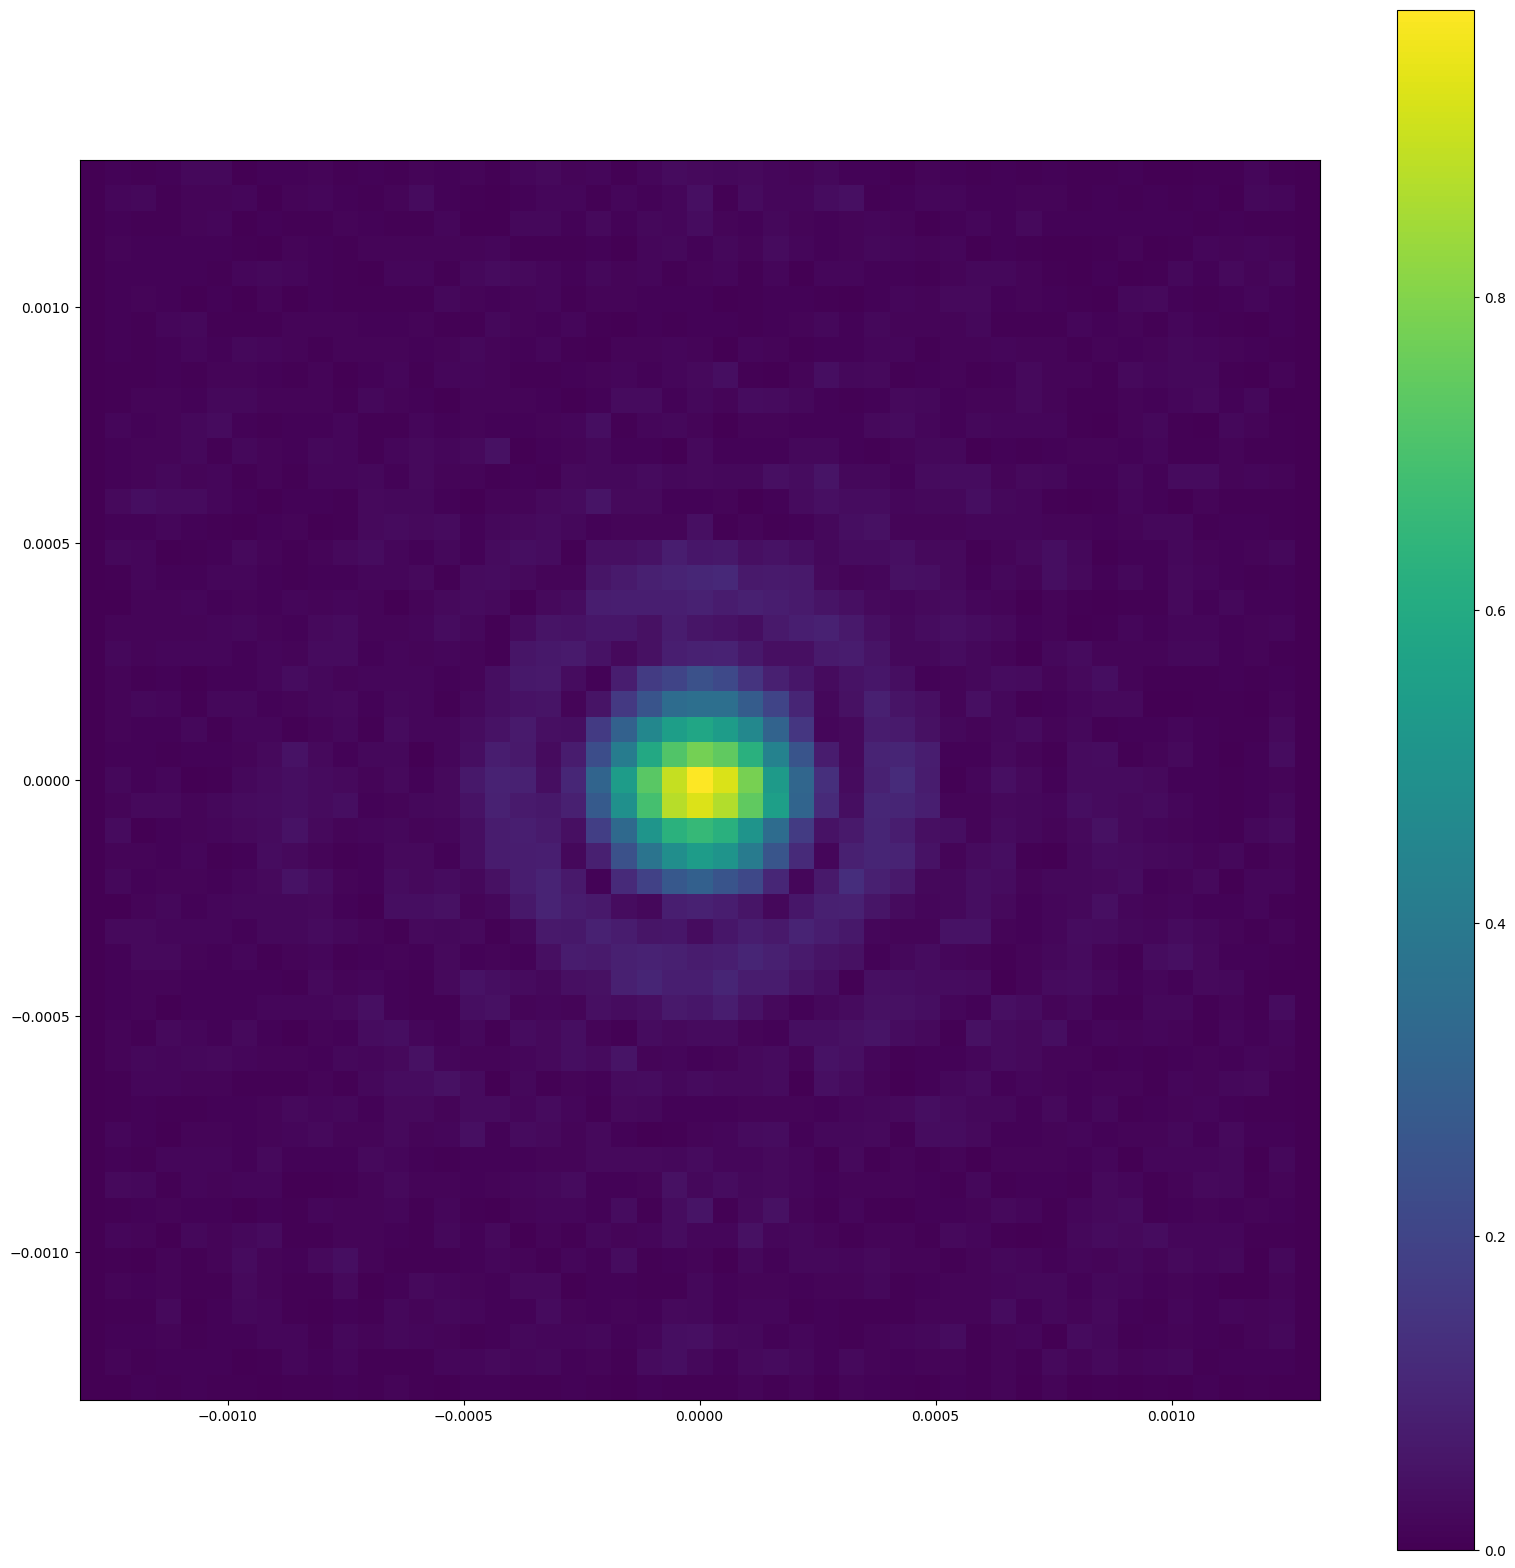

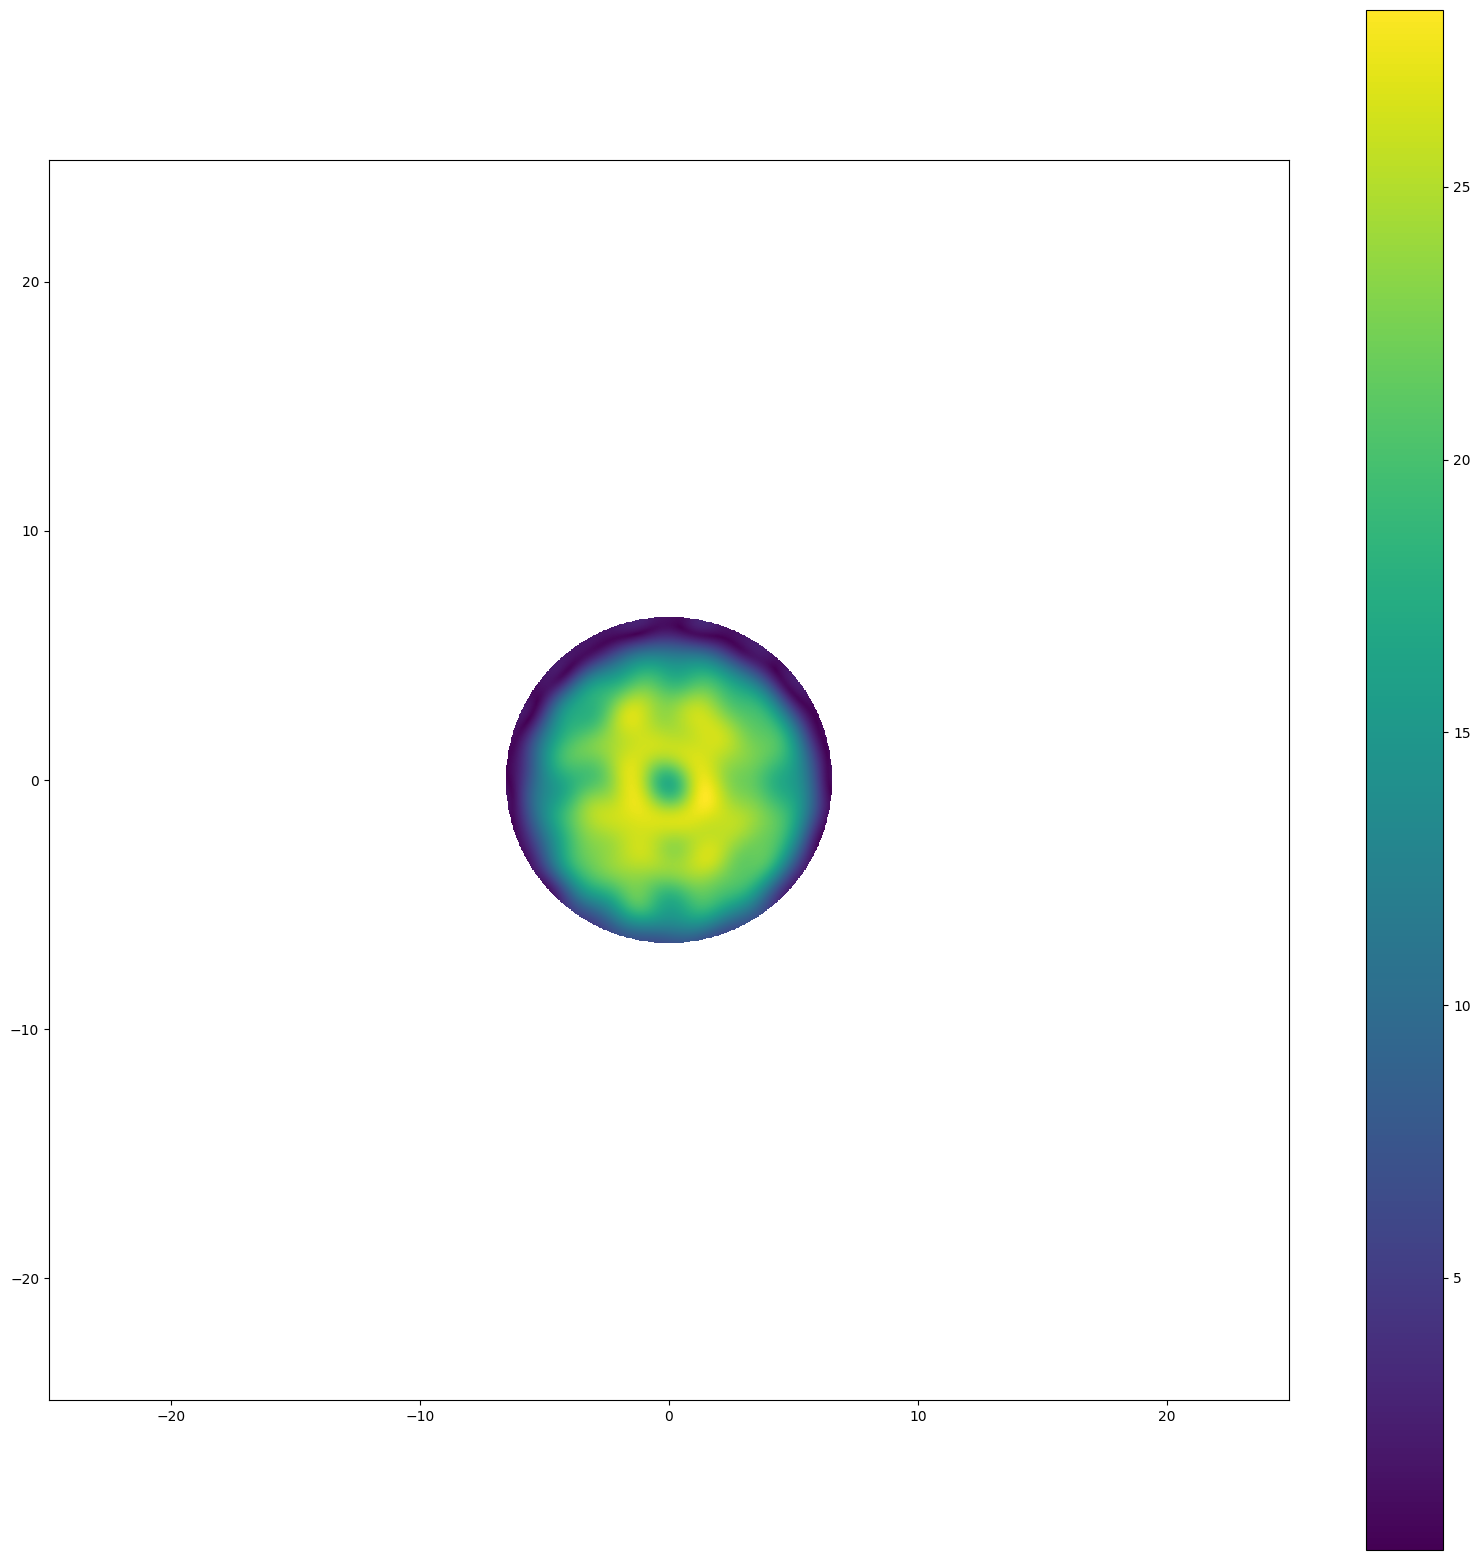

<xarray.Dataset>
Dimensions:          (time: 1, chan: 1, pol: 4, u_prime: 448, v_prime: 448,
                      u: 1695, v: 1695, l: 49, m: 49, ddi: 1)
Coordinates:
  * chan             (chan) float64 1.1e+11
  * ddi              (ddi) <U5 'ddi_0'
  * l                (l) float64 0.001313 0.001259 ... -0.001259 -0.001313
  * m                (m) float64 -0.001313 -0.001259 ... 0.001259 0.001313
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * u                (u) float64 9.132e+03 9.121e+03 ... -9.121e+03 -9.132e+03
  * u_prime          (u_prime) float64 2.415e+03 2.404e+03 ... -2.404e+03
  * v                (v) float64 -9.132e+03 -9.121e+03 ... 9.121e+03 9.132e+03
  * v_prime          (v_prime) float64 -2.415e+03 -2.404e+03 ... 2.404e+03
Dimensions without coordinates: time
Data variables:
    AMPLITUDE        (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 224, 224), meta=np.ndarray>
    APERTURE         (time, chan, pol, u, v) complex128 dask.array<chunksize=(1, 1, 1, 212, 424), meta=np.ndarray>
    BEAM             (time, chan, pol, l, m) complex128 dask.array<chunksize=(1, 1, 4, 49, 49), meta=np.ndarray>
    CORRECTED_PHASE  (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 224, 224), meta=np.ndarray>
Attributes:
    ant_id:               ant_DV13
    ant_name:             DV13
    aperture_resolution:  [1.3178396557682277, 1.3178396557682277]
    ddi:                  ddi_0
    telescope_name:       ALMA
    time_centroid:        5045408559.312

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy
import matplotlib.patches as patches

from scipy import constants

from astrohack.dio import open_image

alma_image = resultsfolder+'/alma.split.image.zarr'

plt.close('all')

chan = 0

ds = open_image("results/alma.split.image.zarr")['ant_DV13']['ddi_0']

wavelength = scipy.constants.speed_of_light/ds.chan.values[chan]
l = ds.l.values
m = ds.m.values
u = ds.u.values*wavelength
v = ds.v.values*wavelength

print(u.min(),u.max())

plt.figure()
plt.imshow(np.abs(ds.BEAM[0,chan,0,:,:]),extent=[l.min(), l.max(), m.min(), m.max()])
plt.colorbar()
plt.show()

circle = patches.Circle((0,0), 12.5, fill=False, color='white', alpha=0.7, linewidth=2)

fig, ax =plt.subplots()

plt.imshow(np.abs(ds.APERTURE[0,chan,0,:,:]),extent=[u.min(), u.max(), v.min(), v.max()])
plt.colorbar()
plt.show()

ds

In [10]:
from astrohack.panel import panel

panel_model = 'rigid'

alma_panel = panel(
    image_name=alma_image, 
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)

2023-07-21 11:19:14,196 - INFO     - astrohack - (_check_parms.py:135) - [panel]: Setting default panel_name to results/alma.split.panel.zarr.
2023-07-21 11:19:14,198 - INFO     - astrohack - (_check_parms.py:135) - [panel]: Setting default ant to all.
2023-07-21 11:19:14,198 - INFO     - astrohack - (_check_parms.py:135) - [panel]: Setting default ddi to all.
2023-07-21 11:19:14,237 - WARNING  - astrohack - (_dio.py:42) - [panel]: results/alma.split.panel.zarr will be overwritten.


Fit failed with the rigid model and a simple mean has been used instead for the following panels: ['DV13', 'ddi_0']
['3-83', '3-81', '4-84']


2023-07-21 11:19:15,810 - INFO     - astrohack - (panel.py:111) - [panel]: Finished processing


In [11]:
import numpy as np
from astrohack.dio import open_panel

def relative_difference(mean, expected):  
    return 2*np.abs(mean - expected)/(abs(mean) + abs(expected))

def verify_panel_positions(
    panel_list=['3-11', '5-31', '7-52', '11-62'], 
    reference_position = np.array([-2.16823971, -0.94590908,  0.84834425, 0.76463105]),
    antenna='ant_DV13',
    ddi='ddi_0'
):
    
    M_TO_MILS = 39370.1
    
    panel_mds = open_panel('results/alma.split.panel.zarr')
    
    panel_position = np.mean(panel_mds[antenna][ddi].sel(labels=panel_list).PANEL_SCREWS.values*M_TO_MILS, axis=1)

    relative_position = relative_difference(panel_position, reference_position)
    
    if np.any(relative_position > 1e-6): 
        print("There were changes!")
        print(relative_position)    

In [12]:
verify_panel_positions(antenna='ant_DV13', ddi='ddi_0')